## Importing Libraries

In [1]:
import numpy as np   
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import time
import psutil
import tracemalloc

In [2]:
from IPython.display import Audio
duration = 0.5  # duration of the beep in seconds
frequency = 220  # frequency of the beep in Hz
sample_rate = 44100  # sampling rate of the beep
t = np.linspace(0, duration, int(duration * sample_rate), False)
beep = np.sin(frequency * t * 2 * np.pi)
beep *= 0.1  # reduce the volume of the beep
beep = np.concatenate([beep,beep])
# play the beep sound
Audio = Audio(beep, rate=sample_rate, autoplay=True)
Audio

## Data Import and Dataframe Creation

In [3]:
empire_airlines_df = pd.read_excel('Empire_Airlines_data.xlsx')


## Deleting Unncessary Columns

In [4]:
empire_airlines_df.drop(['DISTANCE_GROUP',
                     'WEATHER_DELAY',
                     'SECURITY_DELAY',
                     'CARRIER_DELAY',
                     'LATE_AIRCRAFT_DELAY',
                     'NAS_DELAY',
                     'SCHEDULED_ARR_TIME',
                     'SCHEDULED_DEP_TIME',
                     'MARKETING_AIRLINE',
                     'OPERATING_AIRLINE',
                     'DEST_STATE_NM',
                     'ORIGIN_STATE_NM',
                     'ARR_DELAY_NEW',
                     'DEP_DEL15',
                     'DEP_DELAY_NEW',
                     'YEAR'], axis = 1, inplace = True )

## Information

In [5]:
empire_airlines_df.shape

(20598, 13)

In [6]:
empire_airlines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20598 entries, 0 to 20597
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MONTH             20598 non-null  int64 
 1   DAY_OF_MONTH      20598 non-null  int64 
 2   DAY_OF_WEEK       20598 non-null  int64 
 3   ORIGIN_CITY_NAME  20598 non-null  object
 4   DEST_CITY_NAME    20598 non-null  object
 5   TAXI_OUT          20598 non-null  int64 
 6   TAXI_IN           20598 non-null  int64 
 7   ARRIVAL_TARGET    20598 non-null  int64 
 8   AIR_TIME          20598 non-null  int64 
 9   DISTANCE          20598 non-null  int64 
 10  DEP_HOUR          20598 non-null  int64 
 11  ARR_HOUR          20598 non-null  int64 
 12  COVID_EFFECT      20598 non-null  int64 
dtypes: int64(11), object(2)
memory usage: 2.0+ MB


In [7]:
empire_airlines_df.isna().sum()

MONTH               0
DAY_OF_MONTH        0
DAY_OF_WEEK         0
ORIGIN_CITY_NAME    0
DEST_CITY_NAME      0
TAXI_OUT            0
TAXI_IN             0
ARRIVAL_TARGET      0
AIR_TIME            0
DISTANCE            0
DEP_HOUR            0
ARR_HOUR            0
COVID_EFFECT        0
dtype: int64

In [8]:
empire_airlines_df_og = empire_airlines_df.copy()

# Correlation and Mutual Information

In [9]:
obj=[]
num=[]
for i in empire_airlines_df_og.columns:
    if empire_airlines_df_og[i].dtype=="object":
        obj.append(i)
    else:
        num.append(i)
print(obj) 
print(num)

['ORIGIN_CITY_NAME', 'DEST_CITY_NAME']
['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'TAXI_OUT', 'TAXI_IN', 'ARRIVAL_TARGET', 'AIR_TIME', 'DISTANCE', 'DEP_HOUR', 'ARR_HOUR', 'COVID_EFFECT']


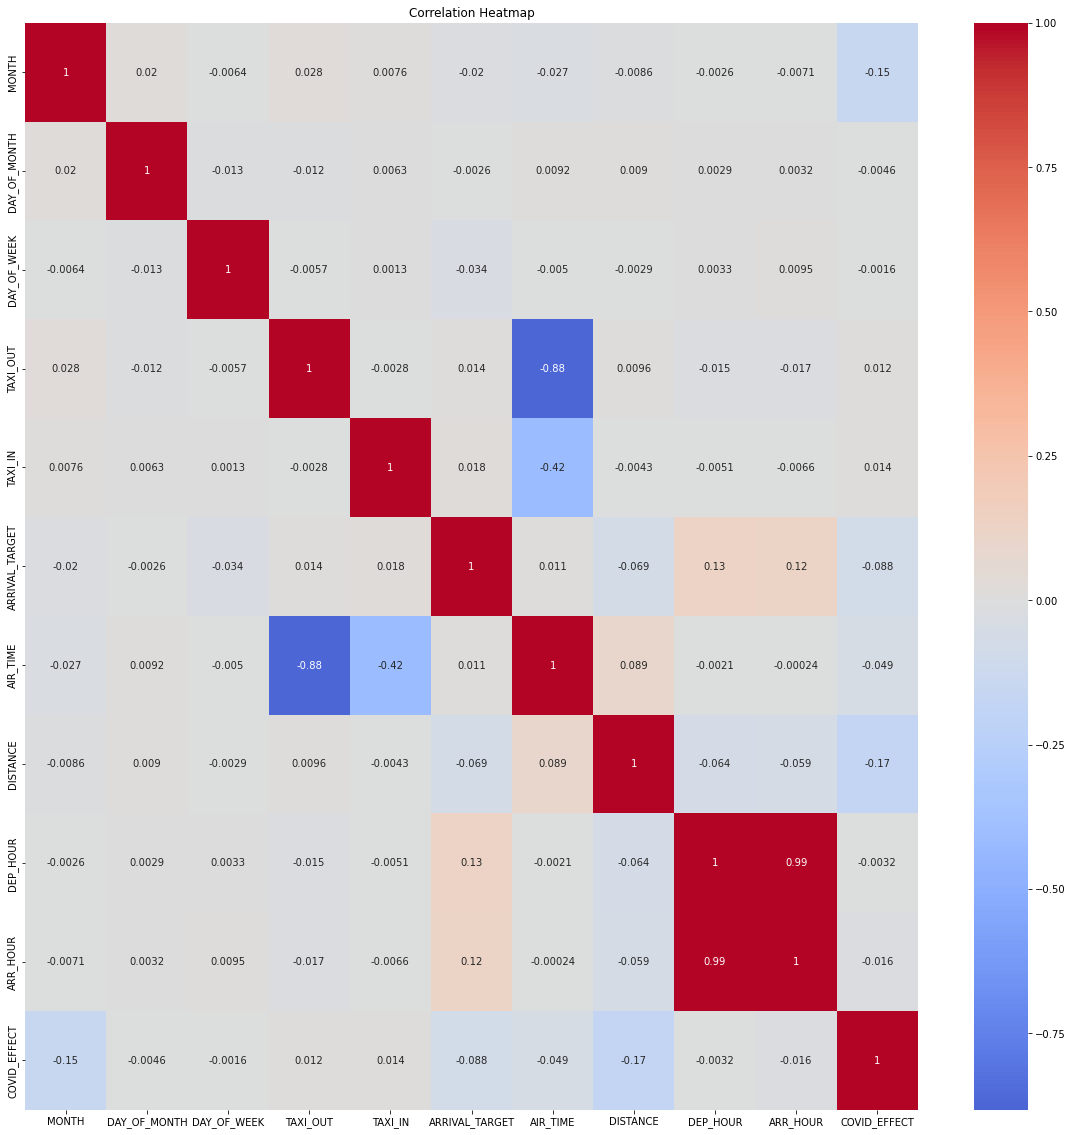

In [10]:
# Calculate the correlation matrix
correlation_matrix = empire_airlines_df[num].corr()

# Set up the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [11]:
# Display the correlations
correlation_with_target = correlation_matrix['ARRIVAL_TARGET']
correlation_with_target = correlation_with_target.sort_values(ascending = False)
# Print the sorted correlations
print(correlation_with_target)

ARRIVAL_TARGET    1.000000
DEP_HOUR          0.126264
ARR_HOUR          0.124816
TAXI_IN           0.018243
TAXI_OUT          0.013689
AIR_TIME          0.011367
DAY_OF_MONTH     -0.002608
MONTH            -0.019575
DAY_OF_WEEK      -0.034215
DISTANCE         -0.068658
COVID_EFFECT     -0.087610
Name: ARRIVAL_TARGET, dtype: float64


In [12]:
# Calculate mutual information between 'ARRIVAL_TARGET' and numeric variables
X_MI = empire_airlines_df_og[num].drop(columns=['ARRIVAL_TARGET'])
Y_MI = empire_airlines_df_og['ARRIVAL_TARGET']

mi_scores = mutual_info_classif(X_MI, Y_MI, random_state=123)

# Create a DataFrame to display mutual information scores
mi_df = pd.DataFrame({'Feature': X_MI.columns, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values(by='MI_Score', ascending=False)

print(mi_df)

        Feature  MI_Score
8      ARR_HOUR  0.013326
7      DEP_HOUR  0.011868
2   DAY_OF_WEEK  0.010799
9  COVID_EFFECT  0.008792
6      DISTANCE  0.007304
1  DAY_OF_MONTH  0.006012
5      AIR_TIME  0.005411
4       TAXI_IN  0.004364
0         MONTH  0.002616
3      TAXI_OUT  0.002102


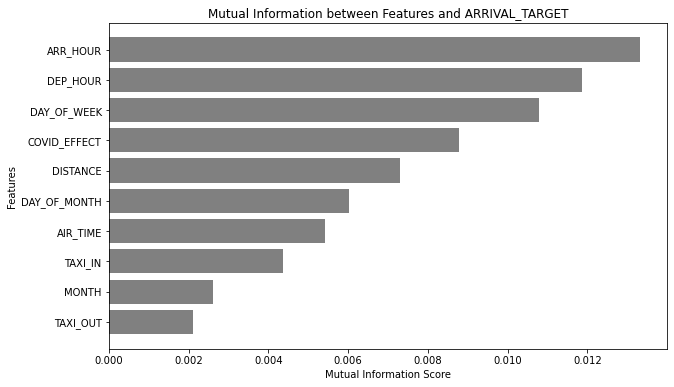

In [13]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['MI_Score'], color='grey')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Mutual Information between Features and ARRIVAL_TARGET')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest MI at the top
plt.show()

# One Hot Encoding

In [14]:
empire_airlines_df_og = pd.get_dummies(empire_airlines_df_og, columns=obj,drop_first=True)

## Train Test Split

In [15]:
X = empire_airlines_df_og.drop(columns=['ARRIVAL_TARGET'])
y = empire_airlines_df_og['ARRIVAL_TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=empire_airlines_df_og['ARRIVAL_TARGET'])

In [16]:
X_train.shape

(14418, 20)

In [17]:
X_test.shape

(6180, 20)

# Logistic Regression

In [18]:
# Start memory and time profiling
start_time = time.time()
process = psutil.Process()

# Define the model to use
logreg = LogisticRegression()

# Define the hyperparameters to tune
logreg_hyperparameters = {
    'C': [0.01, 0.1, 1, 10, 100],
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(logreg, logreg_hyperparameters, cv=5)
grid_search.fit(X_train, y_train)

hyperparameters = grid_search.best_params_

# Print the best hyperparameters and the corresponding performance
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Train the model with the best hyperparameters on the full training set
logreg.set_params(**grid_search.best_params_)
logreg.fit(X_train, y_train)

# Evaluate the model on the train set
y_pred_train = logreg.predict(X_train)

# Evaluate the model on the test set
y_pred_test = logreg.predict(X_test)

# Create DataFrames to store classification metrics
metrics_train = classification_report(y_train, y_pred_train, output_dict=True)
metrics_test = classification_report(y_test, y_pred_test, output_dict=True)

# Convert the dictionaries to DataFrames
log_train = pd.DataFrame(metrics_train).T
log_test = pd.DataFrame(metrics_test).T

# Add an 'AUC' column to the DataFrames
log_train['AUC'] = roc_auc_score(y_train, y_pred_train)
log_test['AUC'] = roc_auc_score(y_test, y_pred_test)

# Concatenate the train and test DataFrames
log_combined = pd.concat([log_train, log_test], keys=['Train', 'Test'])

# Print the combined DataFrame
print(log_combined)


# End time and memory profiling
end_time = time.time()
tracemalloc.stop()

# Print time and memory usage
print(f"Time taken: {end_time - start_time:.2f} seconds")
# Measure initial memory usage
process = psutil.Process()
mem_info = process.memory_info()
mem_usage = mem_info.rss / 1024 / 1024  # Convert to MB
print(f"Final memory usage: {mem_usage:.2f} MB")

Best Hyperparameters: {'C': 0.01}
Best Score: 0.8405464286075098
                    precision    recall  f1-score       support       AUC
Train 0              0.844266  0.993464  0.912809  12087.000000  0.521614
      1              0.594872  0.049764  0.091845   2331.000000  0.521614
      accuracy       0.840893  0.840893  0.840893      0.840893  0.521614
      macro avg      0.719569  0.521614  0.502327  14418.000000  0.521614
      weighted avg   0.803946  0.840893  0.780081  14418.000000  0.521614
Test  0              0.846483  0.994017  0.914336   5181.000000  0.529541
      1              0.677083  0.065065  0.118721    999.000000  0.529541
      accuracy       0.843851  0.843851  0.843851      0.843851  0.529541
      macro avg      0.761783  0.529541  0.516529   6180.000000  0.529541
      weighted avg   0.819099  0.843851  0.785725   6180.000000  0.529541
Time taken: 2.39 seconds
Final memory usage: 259.53 MB


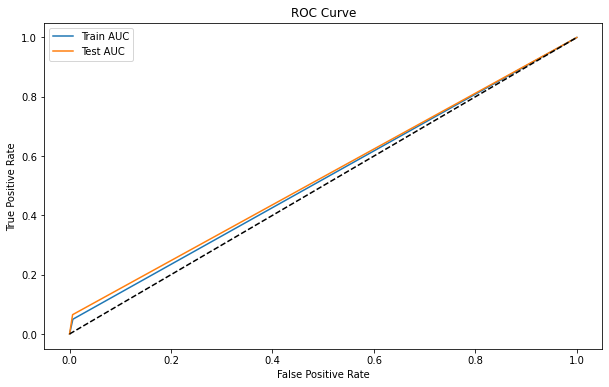

In [19]:
# Plot AUC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label='Train AUC')
plt.plot(fpr_test, tpr_test, label='Test AUC')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [20]:
Audio

# Gaussian Naives Bayes

In [21]:
# Start memory and time profiling
start_time = time.time()
process = psutil.Process()

# Define the model to use (Gaussian Naive Bayes)
nb = GaussianNB()

# Define the hyperparameters to tune for Gaussian Naive Bayes
nb_hyperparameters = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Perform grid search to find the best hyperparameters for Gaussian Naive Bayes
grid_search_nb = GridSearchCV(nb, nb_hyperparameters, cv=5)
grid_search_nb.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding performance for Gaussian Naive Bayes
print(f"Best Hyperparameters (GaussianNB): {grid_search_nb.best_params_}")
print(f"Best Score (GaussianNB): {grid_search_nb.best_score_}")

# Train the Gaussian Naive Bayes model with the best hyperparameters on the full training set
nb.set_params(**grid_search_nb.best_params_)
nb.fit(X_train, y_train)

# Evaluate the Gaussian Naive Bayes model on the train set
y_pred_train_nb = nb.predict(X_train)

# Evaluate the Gaussian Naive Bayes model on the test set
y_pred_test_nb = nb.predict(X_test)

# Create DataFrames to store classification metrics for Gaussian Naive Bayes
metrics_train_nb = classification_report(y_train, y_pred_train_nb, output_dict=True)
metrics_test_nb = classification_report(y_test, y_pred_test_nb, output_dict=True)

# Convert the dictionaries to DataFrames for Gaussian Naive Bayes
nb_train = pd.DataFrame(metrics_train_nb).T
nb_test = pd.DataFrame(metrics_test_nb).T

# Add an 'AUC' column to the DataFrames for Gaussian Naive Bayes (AUC not applicable for Naive Bayes)
nb_train['AUC'] = 'N/A'
nb_test['AUC'] = 'N/A'

# Concatenate the train and test DataFrames for Gaussian Naive Bayes
nb_combined = pd.concat([nb_train, nb_test], keys=['Train', 'Test'])

# Print the combined DataFrame for Gaussian Naive Bayes
print(nb_combined)

# End time and memory profiling
end_time = time.time()
tracemalloc.stop()

# Print time and memory usage
print(f"Time taken: {end_time - start_time:.2f} seconds")
# Measure initial memory usage
process = psutil.Process()
mem_info = process.memory_info()
mem_usage = mem_info.rss / 1024 / 1024  # Convert to MB
print(f"Final memory usage: {mem_usage:.2f} MB")

Best Hyperparameters (GaussianNB): {'var_smoothing': 1e-05}
Best Score (GaussianNB): 0.8007400982275457
                    precision    recall  f1-score       support  AUC
Train 0              0.840165  0.993712  0.910511  12087.000000  N/A
      1              0.377049  0.019734  0.037505   2331.000000  N/A
      accuracy       0.836246  0.836246  0.836246      0.836246  N/A
      macro avg      0.608607  0.506723  0.474008  14418.000000  N/A
      weighted avg   0.765292  0.836246  0.769369  14418.000000  N/A
Test  0              0.839863  0.993052  0.910056   5181.000000  N/A
      1              0.333333  0.018018  0.034188    999.000000  N/A
      accuracy       0.835437  0.835437  0.835437      0.835437  N/A
      macro avg      0.586598  0.505535  0.472122   6180.000000  N/A
      weighted avg   0.757982  0.835437  0.768471   6180.000000  N/A
Time taken: 0.24 seconds
Final memory usage: 231.20 MB


In [22]:
Audio

# Perceptron

In [23]:
# Start memory and time profiling
start_time = time.time()
process = psutil.Process()

# Define the model (Perceptron)
perceptron_classifier = Perceptron()

# Define the hyperparameters to tune for Perceptron
perceptron_hyperparameters = {
    'max_iter': [100, 200, 500],
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1', 'elasticnet']
}

# Perform grid search to find the best hyperparameters for Perceptron
grid_search_perceptron = GridSearchCV(perceptron_classifier, perceptron_hyperparameters, cv=5)
grid_search_perceptron.fit(X_train, y_train)

# Print the best hyperparameters for Perceptron
print(f"Best Hyperparameters (Perceptron): {grid_search_perceptron.best_params_}")

# Train the Perceptron model with the best hyperparameters on the full training set
best_perceptron = grid_search_perceptron.best_estimator_
best_perceptron.fit(X_train, y_train)

# Evaluate the Perceptron model on the train set
y_pred_train_perceptron = best_perceptron.predict(X_train)

# Evaluate the Perceptron model on the test set
y_pred_test_perceptron = best_perceptron.predict(X_test)

# Calculate accuracy for train and test sets
accuracy_train = accuracy_score(y_train, y_pred_train_perceptron)
accuracy_test = accuracy_score(y_test, y_pred_test_perceptron)

# Print accuracy
print(f"Accuracy - Train: {accuracy_train:.2f}")
print(f"Accuracy - Test: {accuracy_test:.2f}")

# Create DataFrames to store classification metrics for Perceptron
metrics_train_perceptron = classification_report(y_train, y_pred_train_perceptron, output_dict=True)
metrics_test_perceptron = classification_report(y_test, y_pred_test_perceptron, output_dict=True)

# Convert the dictionaries to DataFrames for Perceptron
perceptron_train = pd.DataFrame(metrics_train_perceptron).T
perceptron_test = pd.DataFrame(metrics_test_perceptron).T

# Concatenate the train and test DataFrames for Perceptron
perceptron_combined = pd.concat([perceptron_train, perceptron_test], keys=['Train', 'Test'])

# Print the combined DataFrame for Perceptron
print(perceptron_combined)

# End time and memory profiling
end_time = time.time()
tracemalloc.stop()

# Print time and memory usage
print(f"Time taken: {end_time - start_time:.2f} seconds")
# Measure initial memory usage
process = psutil.Process()
mem_info = process.memory_info()
mem_usage = mem_info.rss / 1024 / 1024  # Convert to MB
print(f"Final memory usage: {mem_usage:.2f} MB")

Best Hyperparameters (Perceptron): {'alpha': 0.01, 'max_iter': 100, 'penalty': 'elasticnet'}
Accuracy - Train: 0.84
Accuracy - Test: 0.84
                    precision    recall  f1-score       support
Train 0              0.838327  1.000000  0.912054  12087.000000
      1              0.000000  0.000000  0.000000   2331.000000
      accuracy       0.838327  0.838327  0.838327      0.838327
      macro avg      0.419164  0.500000  0.456027  14418.000000
      weighted avg   0.702792  0.838327  0.764600  14418.000000
Test  0              0.838350  1.000000  0.912068   5181.000000
      1              0.000000  0.000000  0.000000    999.000000
      accuracy       0.838350  0.838350  0.838350      0.838350
      macro avg      0.419175  0.500000  0.456034   6180.000000
      weighted avg   0.702830  0.838350  0.764631   6180.000000
Time taken: 2.76 seconds
Final memory usage: 132.43 MB


In [24]:
Audio

# Random Forest

In [25]:
# Start memory and time profiling
start_time = time.time()
process = psutil.Process()

# Define the model to use (Random Forest)
rf_classifier = RandomForestClassifier()

# Define the hyperparameters to tune for Random Forest
rf_hyperparameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search to find the best hyperparameters for Random Forest
grid_search_rf = GridSearchCV(rf_classifier, rf_hyperparameters, cv=5)
grid_search_rf.fit(X_train, y_train)

rf_best_hyperparameters = grid_search_rf.best_params_

# Print the best hyperparameters and the corresponding performance for Random Forest
print(f"Best Hyperparameters (Random Forest): {grid_search_rf.best_params_}")
print(f"Best Score (Random Forest): {grid_search_rf.best_score_}")

# Train the Random Forest model with the best hyperparameters on the full training set
rf_classifier.set_params(**grid_search_rf.best_params_)
rf_classifier.fit(X_train, y_train)

# Evaluate the Random Forest model on the train set
y_pred_train_rf = rf_classifier.predict(X_train)

# Evaluate the Random Forest model on the test set
y_pred_test_rf = rf_classifier.predict(X_test)

# Create DataFrames to store classification metrics for Random Forest
metrics_train_rf = classification_report(y_train, y_pred_train_rf, output_dict=True)
metrics_test_rf = classification_report(y_test, y_pred_test_rf, output_dict=True)

# Convert the dictionaries to DataFrames for Random Forest
rf_train = pd.DataFrame(metrics_train_rf).T
rf_test = pd.DataFrame(metrics_test_rf).T

# Add an 'AUC' column to the DataFrames for Random Forest
rf_train['AUC'] = roc_auc_score(y_train, y_pred_train_rf)
rf_test['AUC'] = roc_auc_score(y_test, y_pred_test_rf)

# Concatenate the train and test DataFrames for Random Forest
rf_combined = pd.concat([rf_train, rf_test], keys=['Train', 'Test'])

# Print the combined DataFrame for Random Forest
print(rf_combined)

# End time and memory profiling
end_time = time.time()
tracemalloc.stop()

# Print time and memory usage
print(f"Time taken: {end_time - start_time:.2f} seconds")
# Measure initial memory usage
process = psutil.Process()
mem_info = process.memory_info()
mem_usage = mem_info.rss / 1024 / 1024  # Convert to MB
print(f"Final memory usage: {mem_usage:.2f} MB")

Best Hyperparameters (Random Forest): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Score (Random Forest): 0.8488003471495584
                    precision    recall  f1-score       support       AUC
Train 0              0.890882  0.998345  0.941557  12087.000000  0.682141
      1              0.977090  0.365937  0.532459   2331.000000  0.682141
      accuracy       0.896102  0.896102  0.896102      0.896102  0.682141
      macro avg      0.933986  0.682141  0.737008  14418.000000  0.682141
      weighted avg   0.904820  0.896102  0.875417  14418.000000  0.682141
Test  0              0.857047  0.988226  0.917974   5181.000000  0.566686
      1              0.703883  0.145145  0.240664    999.000000  0.566686
      accuracy       0.851942  0.851942  0.851942      0.851942  0.566686
      macro avg      0.780465  0.566686  0.579319   6180.000000  0.566686
      weighted avg   0.832288  0.851942  0.808486   6180.000000  0.566686
Time taken: 46

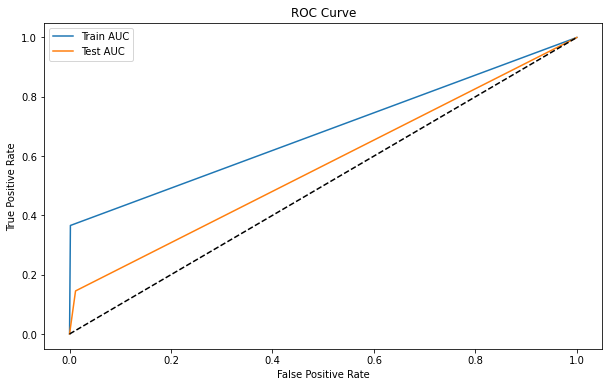

In [26]:
# Plot AUC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_rf)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label='Train AUC')
plt.plot(fpr_test, tpr_test, label='Test AUC')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Data Visualization of Predicted Delays

In [27]:
# Create copies of the original DataFrames with predicted values
empire_airlines_df_train_with_pred = X_train.copy()
empire_airlines_df_test_with_pred = X_test.copy()

# Add the predicted values columns to the copied DataFrames
empire_airlines_df_train_with_pred['PREDICTED_ARRIVAL_DELAY'] = y_pred_train_rf
empire_airlines_df_test_with_pred['PREDICTED_ARRIVAL_DELAY'] = y_pred_test_rf

# Concatenate the training and test DataFrames with predicted values
empire_airlines_df_with_pred = pd.concat([empire_airlines_df_train_with_pred, empire_airlines_df_test_with_pred], axis=0)

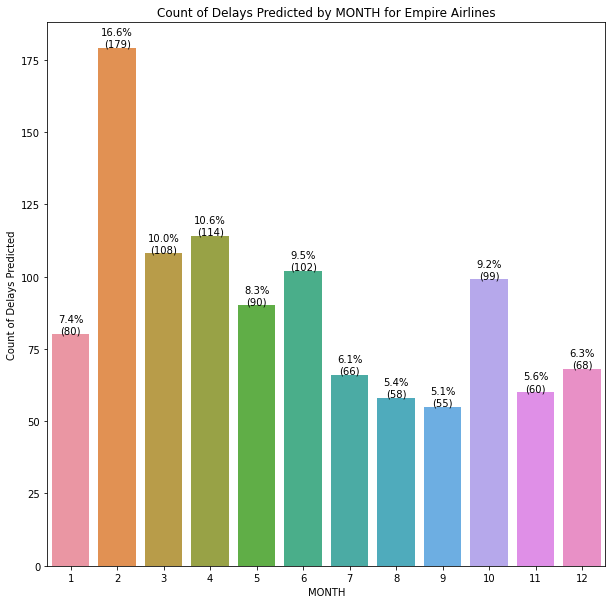

In [28]:
# Filter the DataFrame for predicted arrival delays
filtered_df = empire_airlines_df_with_pred[empire_airlines_df_with_pred['PREDICTED_ARRIVAL_DELAY'] == 1]

# Calculate the total count for normalization
total_count = len(filtered_df)

# Create the count plot
plt.figure(figsize=(10, 10))
ax = sns.countplot(data=filtered_df, x='MONTH')
plt.title("Count of Delays Predicted by MONTH for Empire Airlines") 
plt.xlabel("MONTH")
plt.ylabel("Count of Delays Predicted")

# Add percentage labels and detailed count labels on top of the bars
for p in ax.patches:
    percentage = '{:.1f}%'.format((p.get_height() / total_count) * 100)
    count = int(p.get_height())
    ax.annotate(f'{percentage}\n({count})', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.show()